<h1>Plate plotter</h1>

The following notebook reads your extracted in-focus images folder and plots them in a grid like fashion according to their original position in the plate (well_id). Once you run this notebook you can find the plate images under <code>./output/output_plot.png</code>

You can also plot your resulting object segmentations and visualize them along the entire plate in Napari.

In [2]:
from utils import plot_plate
from apoc import ObjectSegmenter, ObjectClassifier
from pathlib import Path
import tifffile
from skimage.color import rgb2gray
import tqdm
import pyclesperanto_prototype as cle  # version 0.24.1
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.6
import numpy as np
import os 

Used GPU:  <Intel(R) UHD Graphics 630 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>


c:\Users\albertds\mambaforge\envs\napari-devbio\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with TX in their name. Using Intel(R) UHD Graphics 630 instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


You can modify the resolution at which the output plate image is stored (by default 300 dpi, you can increase it according to your needs). Remember the higher dpi the higher space in disk.

6it [00:00, 30.88it/s]
6it [00:00, 29.36it/s]
6it [00:00, 27.54it/s]
6it [00:00, 27.86it/s]


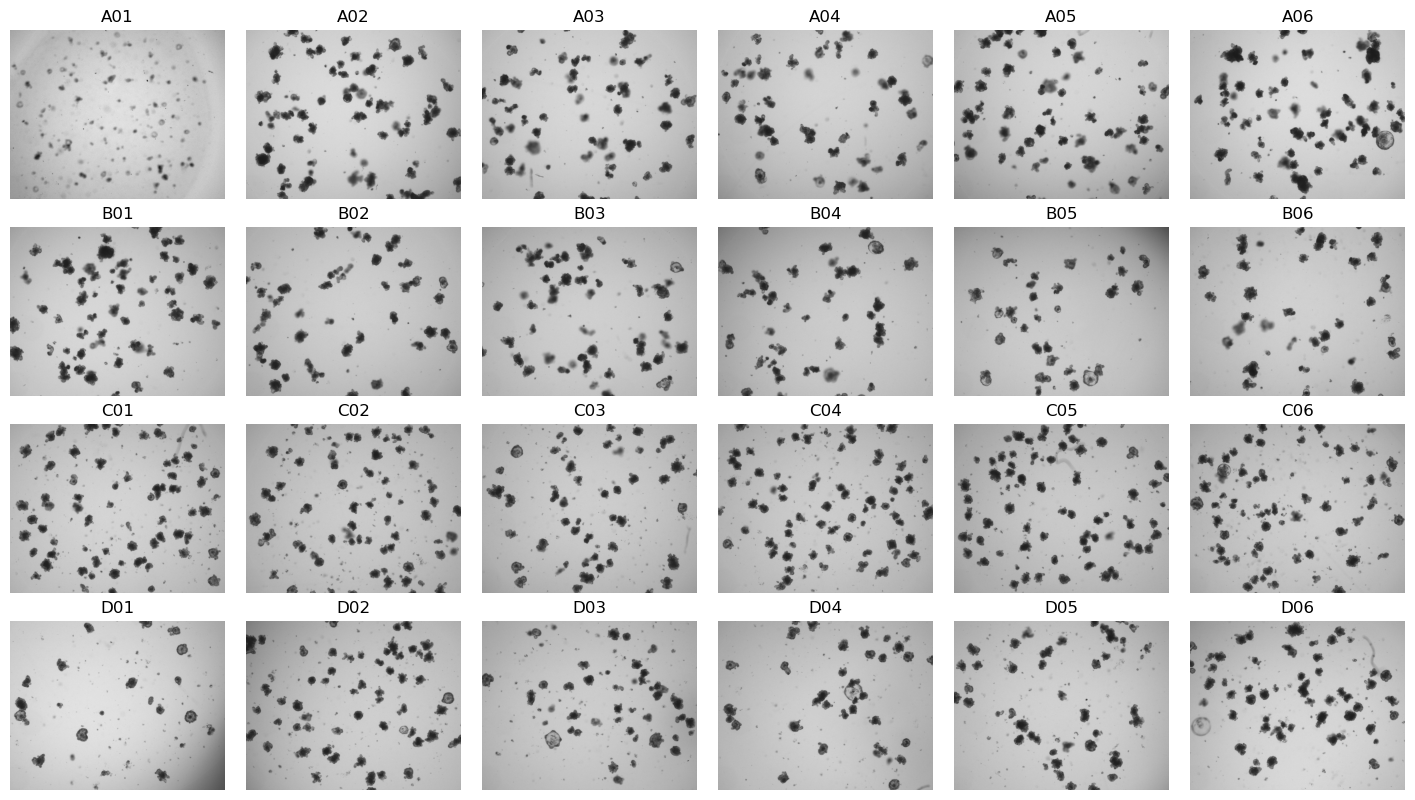

In [5]:
plot_plate(300)

<h2>Label visualization</h2>

You can also apply the trained classifiers for organoid object and organoid in-focus detection to visualize them in the same grid-like fashion

In [3]:

in_focus_organoids = Path("./output/in_focus_organoids/")

segmented_organoids = {}

# Iterate through the files in the directory
for input_img in in_focus_organoids.glob("*.TIF"):
    
    # Get the filename without the extension
    filename = input_img.stem
    
    # Load one RGB image and transform it into grayscale (if needed) for APOC
    rgb_img = tifffile.imread(input_img, is_ome=False)
    if len(rgb_img.shape) < 3:
        img = rgb_img
    elif rgb_img.shape[2] == 3:
        img = rgb2gray(rgb_img)
    else:
        print(
            "Modify the loader to accommodate different file formats",
            rgb_img.shape,
        )

    # Apply object segmenter from APOC
    try:
        segmenter = ObjectSegmenter(opencl_filename="./ObjectSegmenter.cl")
        result = segmenter.predict(image=img)
    except IndexError:
        segmenter = ObjectSegmenter(
            opencl_filename="./pretrained_APOC/ObjectSegmenter.cl"
        )
        result = segmenter.predict(image=img)
        
    # Closing some holes in the organoid labels
    closed_labels = cle.closing_labels(result, None, radius=4.0)

    # Exclude small labels, cutout in pixel area seems to be below 1000px
    exclude_small = cle.exclude_small_labels(closed_labels, None, 1000.0)
    exclude_small = np.array(
        exclude_small, dtype=np.int32
    )  # Change dtype of closed labels to feed array into nsbatwm.split

    # Splitting organoids into a binary mask
    split_organoids = nsbatwm.split_touching_objects(exclude_small, sigma=10.0)

    # Connected component (cc) labeling
    cc_split_organoids = nsbatwm.connected_component_labeling(
        split_organoids, False
    )
    
    # Remove labels on edges
    edge_removed = nsbatwm.remove_labels_on_edges(cc_split_organoids)
        
    segmented_organoids[filename] = edge_removed

In [4]:
# Define the directory path where you want to save the images
output_directory = "./output/segmented_organoids/"

# Iterate through the dictionary and save each array as a .tif file
for filename, cc_split_organoid in segmented_organoids.items():
    # Create a filename for the .tif file within the output_directory
    save_filename = os.path.join(output_directory, f"{filename}.tif")
    
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(save_filename), exist_ok=True)
    
    # Save the cc_split_organoid array as a grayscale .tif file
    tifffile.imwrite(save_filename, cc_split_organoid, photometric="minisblack", dtype=np.int32) 

6it [00:00, 89.97it/s]
6it [00:00, 91.17it/s]
6it [00:00, 95.03it/s]
6it [00:00, 86.50it/s]


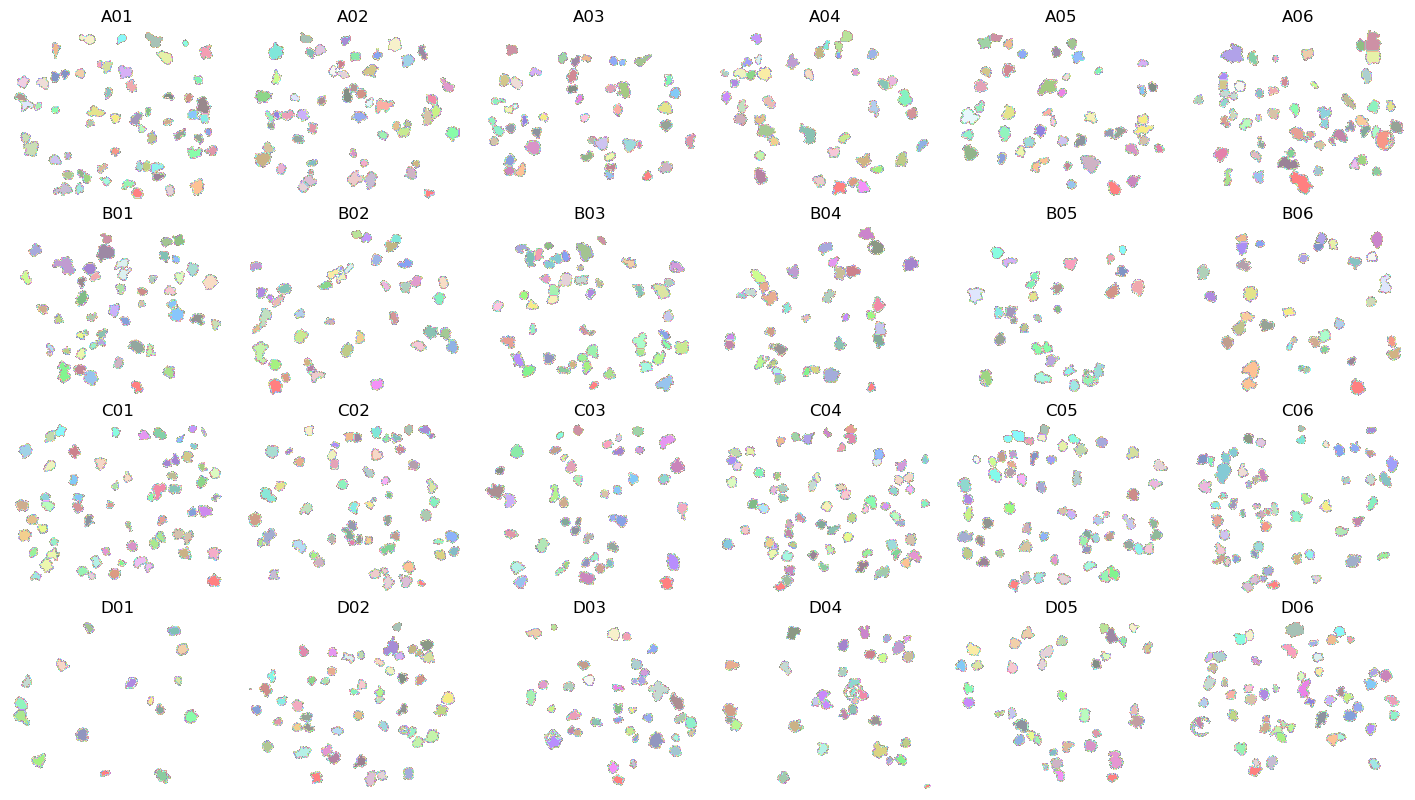

In [5]:
import numpy as np
from matplotlib.colors import ListedColormap

def random_cmap():
    np.random.seed(42)
    cmap = ListedColormap (np.random.rand(256,4))
    # value 0 should just be transparent
    cmap.colors[:,3] = 0.5
    cmap.colors[0,:] = 1
    cmap.colors[0,3] = 0
    
    # if image is a mask, color (last value) should be red
    cmap.colors[-1,0] = 1
    cmap.colors[-1,1:3] = 0
    return cmap

cmap = random_cmap()

plot_plate(
    resolution=300,
    output_path="./output/organoid_object_plot.png",
    img_folder_path="./output/segmented_organoids/",
    colormap=cmap
    )